
# Recommendation System using PySpark

This notebook demonstrates how to build a recommendation system using PySpark. We will use collaborative filtering, a popular recommendation technique, and the Alternating Least Squares (ALS) algorithm to predict user ratings for items and make recommendations.


### Imports

In [6]:
# core
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# spark & ML
import findspark
findspark.init()
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark import StorageLevel
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, when

## Crerate a spark session


In [7]:
#spark.stop()

In [8]:

# create spark session
spark = SparkSession.builder.appName('rec-sys')\
    .config("spark.python.profile.memory","true")\
    .config("spark.driver.memory", "15g")\
    .config("spark.executor.memory", "15g")\
    .getOrCreate()
sc = spark.sparkContext
spark


## Loading Data

First, we load the required datasets. 

The most important dataset is the **book ratings dataset**, which contains the ratings given by users to books.<br>

We also load the books dataset, which contains information about the books for better understanding.


In [9]:
ratings_df = spark.read.csv('BX-Book-Ratings.csv', sep=';', inferSchema=True, header=True)
ratings_df.show(2)

ratings_df.persist(StorageLevel.MEMORY_AND_DISK)

+-------+----------+-----------+
|User-ID|      ISBN|Book-Rating|
+-------+----------+-----------+
| 276725|034545104X|          0|
| 276726|0155061224|          5|
+-------+----------+-----------+
only showing top 2 rows



DataFrame[User-ID: int, ISBN: string, Book-Rating: int]

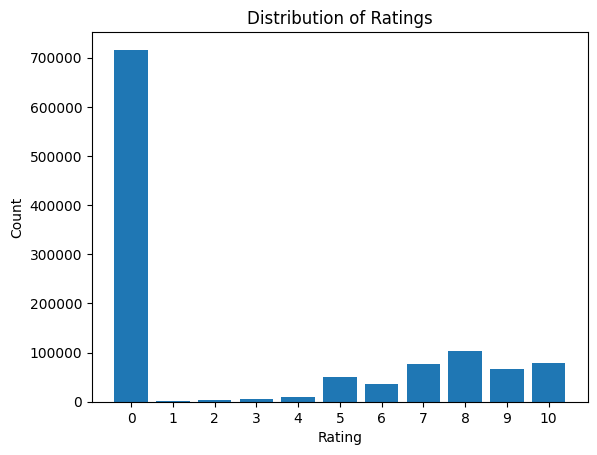

Number of ratings:  1149780
Number of unique users:  105283
Number of unique books:  340556
Number of 0 ratings:  716109
Number of 1 ratings:  1770
Number of 2 ratings:  2759
Number of 3 ratings:  5996
Number of 4 ratings:  8904
Number of 5 ratings:  50974
Number of 6 ratings:  36924
Number of 7 ratings:  76457
Number of 8 ratings:  103736
Number of 9 ratings:  67541
Number of 10 ratings:  78610


In [10]:
# plot the distribution of ratings usng matplotlib and  use in x-axis all the unique ratings and in y-axis the count of each rating
distribution = ratings_df.groupBy('Book-Rating').count().toPandas()
distribution = distribution.sort_values(by='Book-Rating')
plt.bar(distribution['Book-Rating'], distribution['count'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.xticks(distribution['Book-Rating'])
plt.show()

print("Number of ratings: ", ratings_df.count())

print("Number of unique users: ", ratings_df.select('User-ID').distinct().count())

print("Number of unique books: ", ratings_df.select('ISBN').distinct().count())

# print number of 0 ratings 
print("Number of 0 ratings: ", ratings_df.filter(col('Book-Rating') == 0).count())
print("Number of 1 ratings: ", ratings_df.filter(col('Book-Rating') == 1).count())
print("Number of 2 ratings: ", ratings_df.filter(col('Book-Rating') == 2).count())
print("Number of 3 ratings: ", ratings_df.filter(col('Book-Rating') == 3).count())
print("Number of 4 ratings: ", ratings_df.filter(col('Book-Rating') == 4).count())
print("Number of 5 ratings: ", ratings_df.filter(col('Book-Rating') == 5).count())
print("Number of 6 ratings: ", ratings_df.filter(col('Book-Rating') == 6).count())
print("Number of 7 ratings: ", ratings_df.filter(col('Book-Rating') == 7).count())
print("Number of 8 ratings: ", ratings_df.filter(col('Book-Rating') == 8).count())
print("Number of 9 ratings: ", ratings_df.filter(col('Book-Rating') == 9).count())
print("Number of 10 ratings: ", ratings_df.filter(col('Book-Rating') == 10).count())

In [11]:
books_df = spark.read.csv('BX-Books.csv', sep=';', inferSchema=True, header=True)
books_df = books_df.drop('Image-URL-S', 'Image-URL-M', 'Image-URL-L')

books_df.persist(StorageLevel.MEMORY_AND_DISK)
books_df.show(2)

+----------+-------------------+--------------------+-------------------+--------------------+
|      ISBN|         Book-Title|         Book-Author|Year-Of-Publication|           Publisher|
+----------+-------------------+--------------------+-------------------+--------------------+
|0195153448|Classical Mythology|  Mark P. O. Morford|               2002|Oxford University...|
|0002005018|       Clara Callan|Richard Bruce Wright|               2001|HarperFlamingo Ca...|
+----------+-------------------+--------------------+-------------------+--------------------+
only showing top 2 rows




## Data Preprocessing

In this section, we preprocess the data to make it suitable for building the recommendation model. This involves:
- Converting the ISBN column to an integer type
- Splitting the data into training and testing sets

In [12]:
stringToInt = StringIndexer(inputCol='ISBN', outputCol='ISBN_int').fit(ratings_df)  # Convert ISBN string  to int
ratings_dfs = stringToInt.transform(ratings_df)                                     # Add new column ISBN_int
ratings_df = ratings_dfs.filter(ratings_dfs['Book-Rating'] != 0)                    # Remove 0 ratings

ratings_df.persist(StorageLevel.MEMORY_AND_DISK)
ratings_df.show(10)

+-------+----------+-----------+--------+
|User-ID|      ISBN|Book-Rating|ISBN_int|
+-------+----------+-----------+--------+
| 276726|0155061224|          5| 89067.0|
| 276729|052165615X|          3|205984.0|
| 276729|0521795028|          6|206014.0|
| 276736|3257224281|          8| 43132.0|
| 276737|0600570967|          6|216574.0|
| 276744|038550120X|          7|   232.0|
| 276745| 342310538|         10|135627.0|
| 276747|0060517794|          9|  1413.0|
| 276747|0671537458|          9|   914.0|
| 276747|0679776818|          8|  2367.0|
+-------+----------+-----------+--------+
only showing top 10 rows



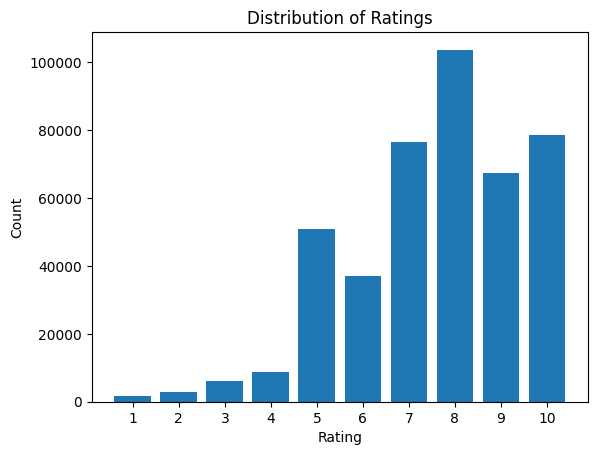

Number of ratings:  433671
Number of unique users:  77805
Number of unique books:  185973
Number of 0 ratings:  0
Number of 1 ratings:  1770
Number of 2 ratings:  2759
Number of 3 ratings:  5996
Number of 4 ratings:  8904
Number of 5 ratings:  50974
Number of 6 ratings:  36924
Number of 7 ratings:  76457
Number of 8 ratings:  103736
Number of 9 ratings:  67541
Number of 10 ratings:  78610


In [13]:
distribution = ratings_df.groupBy('Book-Rating').count().toPandas()
distribution = distribution.sort_values(by='Book-Rating')
plt.bar(distribution['Book-Rating'], distribution['count'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.xticks(distribution['Book-Rating'])
plt.show()
print("Number of ratings: ", ratings_df.count())

print("Number of unique users: ", ratings_df.select('User-ID').distinct().count())

print("Number of unique books: ", ratings_df.select('ISBN').distinct().count())

# print number of 0 ratings
print("Number of 0 ratings: ", ratings_df.filter(col('Book-Rating') == 0).count())
print("Number of 1 ratings: ", ratings_df.filter(col('Book-Rating') == 1).count())
print("Number of 2 ratings: ", ratings_df.filter(col('Book-Rating') == 2).count())
print("Number of 3 ratings: ", ratings_df.filter(col('Book-Rating') == 3).count())
print("Number of 4 ratings: ", ratings_df.filter(col('Book-Rating') == 4).count())
print("Number of 5 ratings: ", ratings_df.filter(col('Book-Rating') == 5).count())
print("Number of 6 ratings: ", ratings_df.filter(col('Book-Rating') == 6).count())
print("Number of 7 ratings: ", ratings_df.filter(col('Book-Rating') == 7).count())
print("Number of 8 ratings: ", ratings_df.filter(col('Book-Rating') == 8).count())
print("Number of 9 ratings: ", ratings_df.filter(col('Book-Rating') == 9).count())
print("Number of 10 ratings: ", ratings_df.filter(col('Book-Rating') == 10).count())

In [86]:
# Transform ISBN_int to integer type
ratings_df = ratings_df.withColumn("ISBN_int", ratings_df["ISBN_int"].cast(IntegerType()))
ratings_df.persist(StorageLevel.MEMORY_AND_DISK)
ratings_df.show(10)

+-------+----------+-----------+--------+
|User-ID|      ISBN|Book-Rating|ISBN_int|
+-------+----------+-----------+--------+
| 276726|0155061224|          5|   89067|
| 276729|052165615X|          3|  205984|
| 276729|0521795028|          6|  206014|
| 276736|3257224281|          8|   43132|
| 276737|0600570967|          6|  216574|
| 276744|038550120X|          7|     232|
| 276745| 342310538|         10|  135627|
| 276747|0060517794|          9|    1413|
| 276747|0671537458|          9|     914|
| 276747|0679776818|          8|    2367|
+-------+----------+-----------+--------+
only showing top 10 rows



split the data into training and testing sets. We will use 80% of the data for training and 20% for testing.

In [87]:
train_df, test_df = ratings_df.randomSplit([0.8,0.2])


## Building the ALS Model

We use the Alternating Least Squares (ALS) algorithm to build the recommendation model.
ALS is particularly well-suited for collaborative filtering with large-scale datasets.

### Steps:
1. **Initialize the ALS model**: Specify parameters like the rank, maximum number of iterations, and regularization parameter.
    - **rank**: The number of features
    - **maxIter**: The maximum number of iterations to run.
    - **regParam**: The regularization parameter to prevent overfitting.

2. **Initialize param_grid**: we will use cross-validation to tune the ALS model. We specify a grid of hyperparameters and use cross-validation to determine the best model.
    - **rank**: [1, 10, 20]
    - **maxIter**: [5, 10, 20]
    - **regParam**: [0.25, 0.35, 0.45]
3. **Initialize CrossValidator**: Specify the estimator (ALS model), evaluator (RegressionEvaluator), paramGrid and number of folds.
4. **Fit the model**: Fit the ALS model to the training data.
5. **Select the best model**: Select the best model based on the cross-validation results.

In [88]:
als = ALS( userCol='User-ID',itemCol='ISBN_int',ratingCol='Book-Rating',
                nonnegative=True, coldStartStrategy="drop")

param_grid = ParamGridBuilder()\
             .addGrid(als.rank, [1])\
             .addGrid(als.maxIter, [20])\
             .addGrid(als.regParam, [0.35])\
             .build()

evaluator = RegressionEvaluator(metricName='rmse', predictionCol='prediction',labelCol='Book-Rating')

crossval = CrossValidator(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=3)

In [89]:
model = crossval.fit(train_df)

In [90]:
rec_model = model.bestModel

print('rank: ', rec_model.rank)
print('MaxIter: ', rec_model._java_obj.parent().getMaxIter())
print('RegParam: ', rec_model._java_obj.parent().getRegParam())

rank:  1
MaxIter:  20
RegParam:  0.35


## Making predictions on test set

In [91]:
predicted_ratings=rec_model.transform(test_df)
predicted_ratings = predicted_ratings.withColumn('prediction', when(col('prediction') > 10, 10).otherwise(col('prediction')))
predicted_ratings.show(20)
predicted_ratings.persist(StorageLevel.MEMORY_AND_DISK)

+-------+----------+-----------+--------+----------+
|User-ID|      ISBN|Book-Rating|ISBN_int|prediction|
+-------+----------+-----------+--------+----------+
|   7253|0451410327|          4|   31565| 6.8967233|
|   8086|0060928336|         10|       3|  7.349378|
|  15447|0671040677|          6|   40202|   3.79987|
|  15957|000716226X|          6|    7983|  5.869425|
|  15957|0061007145|          7|    5624| 6.9440274|
|  15957|0061007161|          5|    4839|  7.459161|
|  15957|0446673544|          9|     910| 5.8144264|
|  18979|042518630X|          4|     656| 6.2074394|
|  22521|0345418778|          8|    6717| 7.4957023|
|  22521|0812561627|          6|   17925| 6.0105414|
|  23271|3404921348|          8|   43164|  8.017485|
|  23271|3492260640|          5|   43300| 6.2987304|
|  23364|0515095826|          6|    1265| 5.9669304|
|  23571|0028604202|          8|    3182|  8.291125|
|  23571|0140042598|          8|     709|  8.498368|
|  23571|0395489318|         10|   22042|  8.8

DataFrame[User-ID: int, ISBN: string, Book-Rating: int, ISBN_int: int, prediction: float]


## Evaluating the Model

After training the model, we evaluate its performance using metrics such as Root Mean Squared Error (RMSE). This helps in understanding how well the model is able to predict user ratings.


In [92]:

evaluator = RegressionEvaluator(metricName='rmse', predictionCol='prediction',labelCol='Book-Rating')
rmse = evaluator.evaluate(predicted_ratings)

print('Root Mean Square Error: ', rmse)

Root Mean Square Error:  2.1557638340538205


## Calculate the precision
By using the test data and the model we calculate the "precision" of the model, which is the number of correct recommendations made by the model divided by the total number of recommendations made by the model.

In [93]:
def precision(predicted, actual):
    v = [1 if pred == actual[i] else 0 for i,pred in enumerate(predicted)]
    m = sum(v)/len(v)
    return m

def precision_threshold(predicted, actual, threshold):
    v = []
    for i, pred in enumerate(predicted):
        if pred <=  actual[i]+threshold and pred >= actual[i]-threshold:
            v.append(1)
        else:
            v.append(0)

    m = sum(v)/len(v)
    return m

Precision: 0.23513302034428796
Precision threshold: 0.829225352112676 with threshold 2


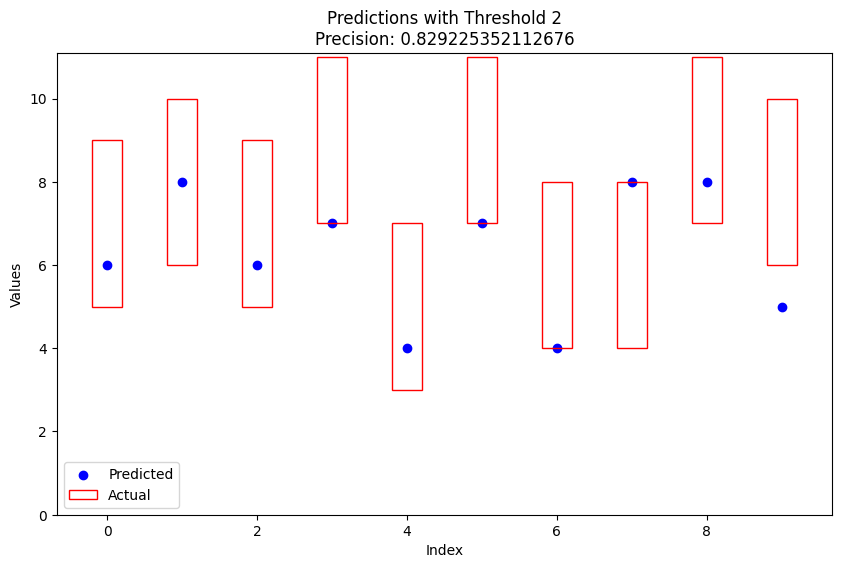

In [94]:
prediction = predicted_ratings.select('prediction').toPandas().values.reshape(-1)
gt = predicted_ratings.select('Book-Rating').toPandas().values.reshape(-1)

prediction = np.round(prediction)

threshold = 2

print(f'Precision: {precision(prediction[:], gt[:])}')

print(f'Precision threshold: {precision_threshold(prediction[:], gt[:], threshold)} with threshold {threshold}')



# Create scatter plot
plt.figure(figsize=(10, 6))
# set y axist from 0 to 10
plt.ylim(0, 11.1)

plt.scatter(range(len( prediction[100:110])),  list(map(float, prediction[100:110])), color='blue', label='Predicted')

for i in range(len(gt[100:110])):
    plt.gca().add_patch(Rectangle((i-0.2,int(gt[i+100])-threshold),0.4,2*threshold,
                    edgecolor='red',
                    facecolor='none',
                    lw=1))
plt.gca().legend(('Predicted', 'Actual'))
plt.xlabel('Index')
plt.ylabel('Values')
plt.title(f'Predictions with Threshold {threshold}\nPrecision: {precision_threshold(prediction[:], gt[:], threshold)}')
plt.show()



## Making Recommendations

Once the model is trained and evaluated, we use it to make recommendations for users. The model predicts ratings for items that a user has not rated yet, and we recommend the items with the highest predicted ratings.


In [129]:
# function to recommend top-n books for a user using trained model
def recommend_for_user(user_id, n):
    ratings_user = ratings_df.filter(col('User-Id')==user_id)
    pred_ratings_user = rec_model.transform(ratings_user)
    recs_user = books_df.join(pred_ratings_user.select(['ISBN', 'prediction']), on='ISBN')
    recs_user.persist(StorageLevel.MEMORY_AND_DISK)
    recs_user = recs_user.sort('prediction', ascending=False).drop('prediction').limit(n)
    return recs_user, pred_ratings_user

In [132]:
user_id = 35859

recs_user, pred_ratings_user = recommend_for_user(user_id, 20)
print(f"Recommendations for user {user_id}:")
recs_user.show()

Recommendations for user 35859:
+----------+--------------------+--------------------+-------------------+--------------------+
|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|
+----------+--------------------+--------------------+-------------------+--------------------+
|030723102X|The Sesame Street...| Emily Perl Kingsley|               1980|Western Pub. Co. ...|
|0760707251|Charlottes Web Sp...|           E B White|               1997|  Barnes Noble Books|
|0816735107|Halloween Magic (...|          Rita Walsh|               1994|Troll Communications|
|0307105458|Richard Scarry's ...|         HUCK SCARRY|               2003|        Golden Books|
|0689803672|Richard Scarry: T...|      Richard Scarry|               1995|     Simon Spotlight|
|0835911071|Star Trek Next Ge...|       John Vornholt|               1994|        Globe Fearon|
|055325605X|Belles on Their Toes|   FRANK B. GILBRETH|               1984|              Bantam|
|0694008

In [133]:
# pred_ratings_user = pred_ratings_user.withColumn('prediction', when(col('prediction') > 10, 10).otherwise(col('prediction')))
pred_ratings_user.sort('prediction', ascending=False).show(20)

+-------+----------+-----------+--------+----------+
|User-ID|      ISBN|Book-Rating|ISBN_int|prediction|
+-------+----------+-----------+--------+----------+
|  35859|030723102X|          8|   13175|  9.967698|
|  35859|0760707251|         10|   53493|  9.675309|
|  35859|0816735107|         10|   76288|  9.656375|
|  35859|0760702152|         10|  238778|  9.544891|
|  35859|0307760278|         10|   60855|  9.544891|
|  35859|0762411236|         10|  239348|  9.544891|
|  35859|0307101630|         10|   29354|  9.544891|
|  35859|0307115356|         10|   60725|  9.544891|
|  35859|0307115364|         10|   90272|  9.544891|
|  35859|0307120252|         10|   90311|  9.544891|
|  35859|0394834550|         10|  187208|  9.544891|
|  35859|067981230X|         10|  225211|  9.544891|
|  35859| 059016555|         10|  213791|  9.544891|
|  35859|0064460118|         10|  150938|  9.544891|
|  35859|0717284662|         10|  115580|  9.544891|
|  35859|0307231070|         10|   90446|  9.5

In [98]:
#spark.stop()